In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
import keras.backend as K

from tqdm import tqdm

%matplotlib inline

In [2]:
IMAGES_DIRECTORY = os.path.join("/kaggle/input/marketplace-navigation-dataset/dataset/images")
LABELS_PATH = os.path.join("/kaggle/input/marketplace-navigation-dataset/dataset/market_dataset_xy.txt")
DRONET_PATH = os.path.join("/kaggle/input/marketplace-navigation-dataset/model.keras")

# Loading Dataset

In [3]:
original_df = pd.read_csv(LABELS_PATH, sep=" ", header=None)
original_df.columns = ["file name", "-", "datetime", "y_vel", "x_vel"]

df = pd.DataFrame()
df["file path"] = original_df["file name"].apply(lambda file_name: os.path.join(IMAGES_DIRECTORY, file_name))
df["x_vel"] = original_df["x_vel"]
df["y_vel"] = original_df["y_vel"]

df

,file path,x_vel,y_vel
0,/kaggle/input/marketplace-navigation-dataset/d...,0.0390,0.0253
1,/kaggle/input/marketplace-navigation-dataset/d...,-0.0693,0.0593
2,/kaggle/input/marketplace-navigation-dataset/d...,0.0233,0.1089
3,/kaggle/input/marketplace-navigation-dataset/d...,0.0485,0.1407
4,/kaggle/input/marketplace-navigation-dataset/d...,-0.0469,0.1870
...,...,...,...
2265,/kaggle/input/marketplace-navigation-dataset/d...,0.0303,0.1485
2266,/kaggle/input/marketplace-navigation-dataset/d...,-0.0346,0.1026
2267,/kaggle/input/marketplace-navigation-dataset/d...,0.0760,0.0966
2268,/kaggle/input/marketplace-navigation-dataset/d...,-0.0563,0.0644


In [4]:
def load_images(df, target_size: tuple[int, int]=(224, 224), color_mode: str="rgb"):
    X = []
    y = []
    
    for file_path, x_vel, y_vel in tqdm(df.itertuples(index=False, name=None)):
        image = keras.utils.load_img(
            file_path,
            color_mode=color_mode,
            target_size=target_size,
            interpolation="bilinear",
        )
        image = np.asarray(image, dtype=np.float32) / 255.0  # Efficient conversion
    
        X.append(image)
        y.append([x_vel, y_vel])
    
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

In [5]:
X, y = load_images(df, target_size=(200, 200), color_mode="grayscale")

# Split samples into train (60%), validation(20%) and test(20%) subsets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    train_size=0.6,
    shuffle=True,
    random_state=0,
)

X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp,
    train_size=0.5,
    shuffle=True,
    random_state=0,
)

2270it [04:31,  8.37it/s]


In [6]:
from keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True, augment_data=False, **kwargs):
        super().__init__(**kwargs)
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        self.augment_data = augment_data
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return len(self.X) // self.batch_size

    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError("Out of range")
        
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        batch_X = []
        batch_y = []
        
        for i in batch_indexes:
            image = self.X[i][..., np.newaxis].astype('float32')
            label = self.y[i].astype('float32')
        
            if self.augment_data:
                image, label = self.augment(image, label)
            
            batch_X.append(image)
            batch_y.append(label)

        batch_X = np.stack(batch_X)
        batch_y = np.stack(batch_y)

        return batch_X, {
            "Dronet_output_x": batch_y[:, 0],
            "Dronet_output_y": batch_y[:, 1],
        }

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    @staticmethod
    def augment(image, label):
        image = tf.convert_to_tensor(image)
        label = tf.convert_to_tensor(label)
    
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
        if tf.random.uniform([]) > 0.5:
            image = tf.image.flip_left_right(image)
            label = tf.stack([-label[0], label[1]])
    
        return image.numpy(), label.numpy()

In [7]:
@tf.function
def mae(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])
    
    return tf.reduce_sum(tf.abs(y_true - y_pred))
@tf.function

def r2_score(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])
    
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    
    return 1 - (ss_res / (ss_tot + K.epsilon()))
@tf.function

def rmse(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])
    
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

@tf.function
def eva(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])

    numerator = tf.math.reduce_variance(y_true - y_pred)
    denominator = tf.math.reduce_variance(y_true) + tf.keras.backend.epsilon()
    
    return 1.0 - numerator / denominator

def create_dronet(learning_rate, name="Dronet", bottom_layers=(512, 256), batch_normalization_layers=(1,), dropout_layers=(1,)):
    base = keras.models.load_model(DRONET_PATH)
    base.name = "Dronet_cnn_layers"
    base.trainable = False
    
    inputs = base.input
    conv_layers = base.output

    if len(conv_layers.shape) > 2:
        s = keras.layers.Flatten(name="Dronet_flatten")(conv_layers)
    else:
        s = conv_layers  

    s = keras.layers.ReLU(name="Dronet_relu")(s)
    s = keras.layers.Dropout(0.5, name="Dronet_shared_dropout")(s)

    x = s
    for i, units in enumerate(bottom_layers, 1):
        x = keras.layers.Dense(units, name=f"Dropout_x_dense_{i}")(x)

        if i in batch_normalization_layers:
            x = keras.layers.BatchNormalization(name=f"Dronet_x_batchnorm_{i}")(x)
        
        x = keras.layers.ReLU(name=f"Dronet_x_relu_{i}")(x)

        if i in dropout_layers:
            x = keras.layers.Dropout(0.5, name=f"Dronet_x_dropout_{i}")(x)

    y = s
    for i, units in enumerate(bottom_layers, 1):
        y = keras.layers.Dense(units, name=f"Dropout_y_dense_{i}")(y)
        
        if i in batch_normalization_layers:
            y = keras.layers.BatchNormalization(name=f"Dronet_y_batchnorm_{i}")(y)
            
        y = keras.layers.ReLU(name=f"Dronet_y_relu_{i}")(y)
        
        if i in dropout_layers:
            y = keras.layers.Dropout(0.5, name=f"Dronet_y_dropout_{i}")(y)
    
    outputs = [
        keras.layers.Dense(1, activation="linear", name="Dronet_output_x")(x),
        keras.layers.Dense(1, activation="linear", name="Dronet_output_y")(y),
    ]

    model = keras.Model(inputs=inputs, outputs=outputs, name=name)

    model.compile(
        loss={
            "Dronet_output_x": "mean_squared_error",
            "Dronet_output_y": "mean_squared_error",
        },
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics={
            "Dronet_output_x": [eva, rmse, r2_score],
            "Dronet_output_y": [eva, rmse, r2_score],
        },
    )

    return model

In [8]:
def train_model(model, train_dataset, validation_dataset):
    # kwargs = {
    #     "workers": 4,
    #     "use_multiprocessing": True,
    # }
    
    return model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=200,
        verbose=0,
        callbacks=[
            # keras.callbacks.EarlyStopping(
            #     monitor="val_Dronet_output_x_rmse",
            #     patience=30,
            #     min_delta=1e-4,
            #     mode="min"
            # ),
            keras.callbacks.ReduceLROnPlateau(
                monitor="val_Dronet_output_x_rmse",
                patience=10,
                factor=0.5,
                min_lr=1e-7,
                mode="min"
            ),
        ],
    )

def plot_training(histories):
    rows = len(histories)
    columns = 2
    figsize = (columns * 4, rows * 4)

    fig, ax = plt.subplots(rows, columns, figsize=figsize, layout="tight")

    for index, history in enumerate(histories):
        ax[index, 0].plot(history.history["Dronet_output_x_rmse"], label="Training RMSE")
        ax[index, 0].plot(history.history["val_Dronet_output_x_rmse"], label="Validation RMSE")
        ax[index, 0].legend()
        ax[index, 0].set_title(f"{history.model.name} Horizontal speed")
        
        ax[index, 1].plot(history.history["Dronet_output_y_rmse"], label="Training RMSE")
        ax[index, 1].plot(history.history["val_Dronet_output_y_rmse"], label="Validation RMSE")
        ax[index, 1].legend()
        ax[index, 1].set_title(f"{history.model.name} Vertical speed")

def compare_models(models, test_dataset):
    metrics = {}

    rows = len(models)
    columns = 4
    figsize = (columns * 4, rows * 4)
    
    fig, ax = plt.subplots(rows, columns, figsize=figsize, layout="compressed")
    
    for i, model in enumerate(models):
        y_true, y_pred = [], []

        metrics_names = [
            "MSE", "Horizontal EVA", "Horizontal R²", "Horizontal RMSE",
            "Vertical EVA", "Vertical R²", "Vertical RMSE"
        ]
        model_metrics = model.evaluate(test_dataset, verbose=0)
        model_metrics = dict(zip(metrics_names, model_metrics))
        metrics[model.name] = model_metrics
        
        for sample_batch, y_true_batch in test_dataset:
            y_pred_batch = model.predict(sample_batch, verbose=0)
            y_pred_batch = np.hstack(y_pred_batch)

            y_true_batch = np.array([
                y_true_batch["Dronet_output_x"],
                y_true_batch["Dronet_output_y"],
            ])
            y_true_batch= y_true_batch.T

            y_true.append(y_true_batch)
            y_pred.append(y_pred_batch)

        y_true = np.vstack(y_true)
        y_pred = np.vstack(y_pred)
        
        x_residuals = y_true[:, 0] - y_pred[:, 0]
        x_limits = np.max(np.fabs(x_residuals))
        x_limits = (-x_limits, +x_limits)
    
        y_residuals = y_true[:, 1] - y_pred[:, 1]
        y_limits = np.max(np.fabs(y_residuals))
        y_limits = (-y_limits, +y_limits)
    
        ax[i, 0].scatter(y_true[:, 0], y_pred[:, 0])
        ax[i, 0].set_title(f"{model.name}\nHorizintal speed scatter")
        ax[i, 0].set_xlabel("Actual values")
        ax[i, 0].set_ylabel("Predicted values")
        
        ax[i, 1].hist(x_residuals)
        ax[i, 1].set_title(f"{model.name}\nHorizontal prediction errors distribution")
        ax[i, 1].set_ylabel("Error")
        ax[i, 1].set_xlim(x_limits)
    
        ax[i, 2].scatter(y_true[:, 1], y_pred[:, 1])
        ax[i, 2].set_title(f"{model.name}\nVertical speed scatter")
        ax[i, 2].set_xlabel("Actual values")
        ax[i, 2].set_ylabel("Predicted values")

        ax[i, 3].hist(y_residuals)
        ax[i, 3].set_title(f"{model.name}\nVertical prediction errors distribution")
        ax[i, 3].set_ylabel("Error")
        ax[i, 3].set_xlim(y_limits)

    print(pd.DataFrame(metrics).T)

I0000 00:00:1743605839.388783      66 service.cc:145] XLA service 0x7da7c4003510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743605839.388848      66 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1743605842.284268      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


              MSE  Horizontal EVA  Horizontal R²  Horizontal RMSE  \
DR-Y00A  0.160375        0.813360       0.807491         0.243288   
DR-X00A  0.154111        0.792781       0.788866         0.238454   
DR-900A  0.163461        0.772734       0.765693         0.257009   
DR-800A  0.173023        0.746795       0.734617         0.258248   
DR-700A  0.201185        0.749196       0.743976         0.276027   
DR-Y00B  0.333094        0.479214       0.468436         0.338683   
DR-X00B  0.337829        0.645535       0.631922         0.338794   
DR-900B  0.338314        0.527527       0.510325         0.352491   
DR-800B  0.410546        0.503391       0.474728         0.373210   
DR-700B  0.439598        0.414563       0.400422         0.402352   
DR-X90A  0.092724        0.800168       0.795089         0.216575   
DR-980A  0.112769        0.777210       0.771909         0.223050   
DR-870A  0.122571        0.761671       0.753605         0.234014   
DR-760A  0.140164        0.711002 

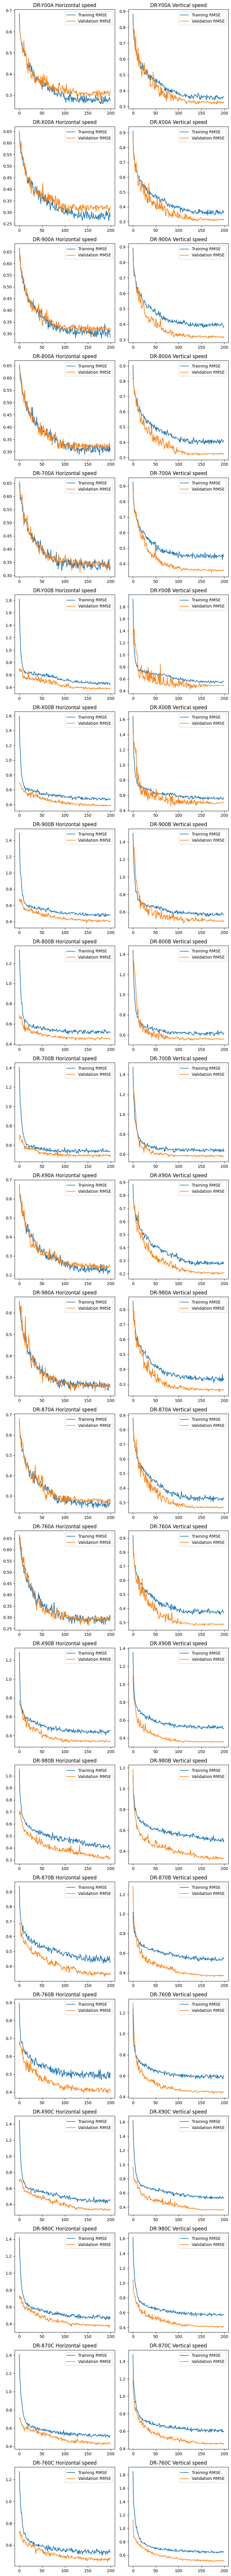

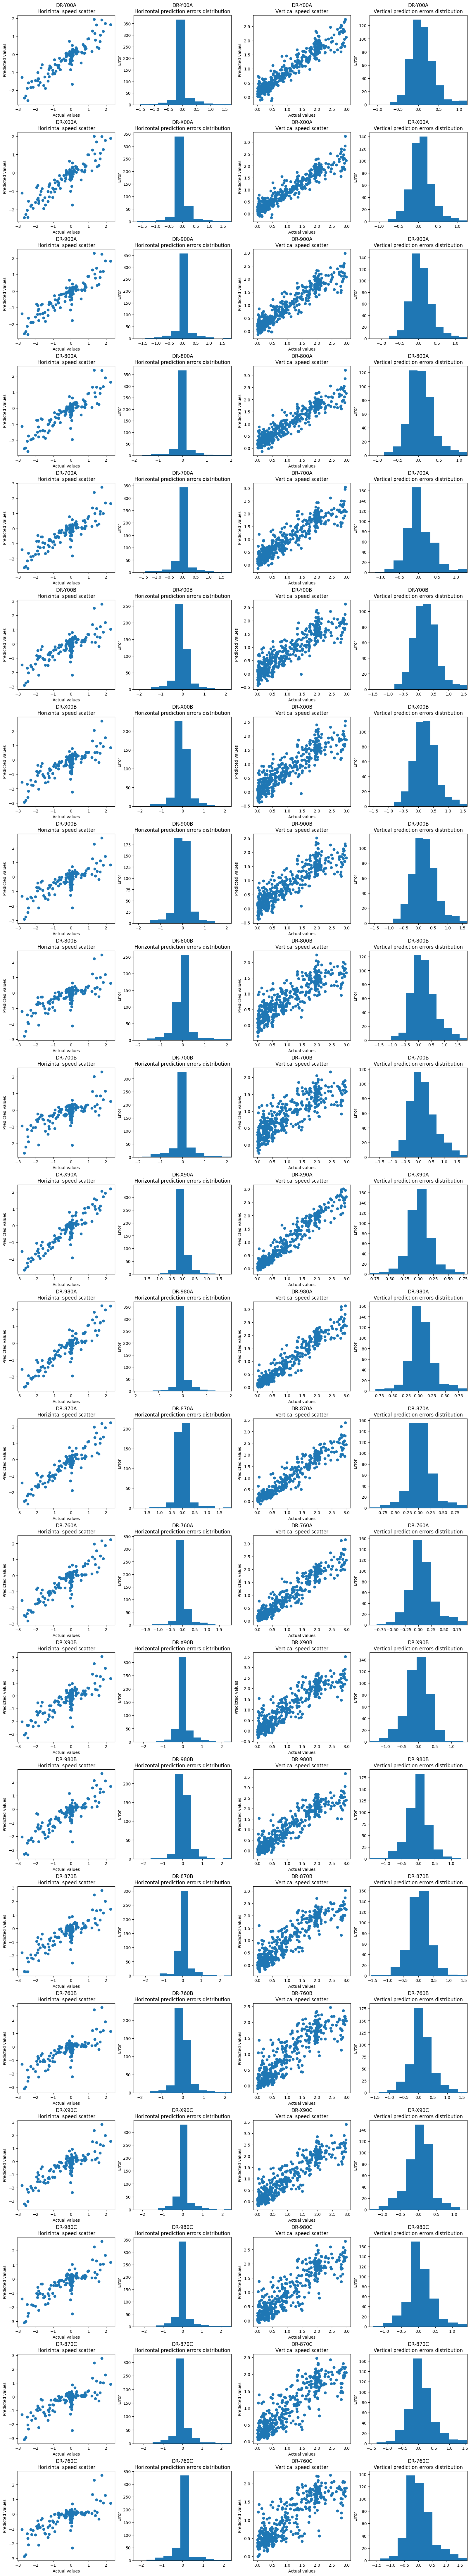

In [9]:
np.random.seed(0)
train_dataset = DataGenerator(X_train, y_train, augment_data=True)
validation_dataset = DataGenerator(X_val, y_val)
test_dataset = DataGenerator(X_test, y_test)

models = [
    create_dronet(0.001, name="DR-Y00A", bottom_layers=(2024,), batch_normalization_layers=(), dropout_layers=()),
    create_dronet(0.001, name="DR-X00A", bottom_layers=(1024,), batch_normalization_layers=(), dropout_layers=()),
    create_dronet(0.001, name="DR-900A", bottom_layers=( 512,), batch_normalization_layers=(), dropout_layers=()),
    create_dronet(0.001, name="DR-800A", bottom_layers=( 256,), batch_normalization_layers=(), dropout_layers=()),
    create_dronet(0.001, name="DR-700A", bottom_layers=( 128,), batch_normalization_layers=(), dropout_layers=()),
    create_dronet(0.001, name="DR-Y00B", bottom_layers=(2024,), batch_normalization_layers=(1,), dropout_layers=(1,)),
    create_dronet(0.001, name="DR-X00B", bottom_layers=(1024,), batch_normalization_layers=(1,), dropout_layers=(1,)),
    create_dronet(0.001, name="DR-900B", bottom_layers=( 512,), batch_normalization_layers=(1,), dropout_layers=(1,)),
    create_dronet(0.001, name="DR-800B", bottom_layers=( 256,), batch_normalization_layers=(1,), dropout_layers=(1,)),
    create_dronet(0.001, name="DR-700B", bottom_layers=( 128,), batch_normalization_layers=(1,), dropout_layers=(1,)),
    create_dronet(0.001, name="DR-X90A", bottom_layers=(1024, 512,), batch_normalization_layers=(), dropout_layers=()),
    create_dronet(0.001, name="DR-980A", bottom_layers=( 512, 256,), batch_normalization_layers=(), dropout_layers=()),
    create_dronet(0.001, name="DR-870A", bottom_layers=( 256, 128,), batch_normalization_layers=(), dropout_layers=()),
    create_dronet(0.001, name="DR-760A", bottom_layers=( 128,  64,), batch_normalization_layers=(), dropout_layers=()),
    create_dronet(0.001, name="DR-X90B", bottom_layers=(1024, 512,), batch_normalization_layers=(1, 2,), dropout_layers=(1,)),
    create_dronet(0.001, name="DR-980B", bottom_layers=( 512, 256,), batch_normalization_layers=(1, 2,), dropout_layers=(1,)),
    create_dronet(0.001, name="DR-870B", bottom_layers=( 256, 128,), batch_normalization_layers=(1, 2,), dropout_layers=(1,)),
    create_dronet(0.001, name="DR-760B", bottom_layers=( 128,  64,), batch_normalization_layers=(1, 2,), dropout_layers=(1,)),
    create_dronet(0.001, name="DR-X90C", bottom_layers=(1024, 512,), batch_normalization_layers=(1, 2,), dropout_layers=(1, 2)),
    create_dronet(0.001, name="DR-980C", bottom_layers=( 512, 256,), batch_normalization_layers=(1, 2,), dropout_layers=(1, 2)),
    create_dronet(0.001, name="DR-870C", bottom_layers=( 256, 128,), batch_normalization_layers=(1, 2,), dropout_layers=(1, 2)),
    create_dronet(0.001, name="DR-760C", bottom_layers=( 128,  64,), batch_normalization_layers=(1, 2,), dropout_layers=(1, 2)),
]

histories = [train_model(model, train_dataset, validation_dataset) for model in models]
plot_training(histories)
compare_models(models, test_dataset)